In [1]:
import numpy as np
from ps_utils import *
import matplotlib.pyplot as plt

Using pseudo-inverse:

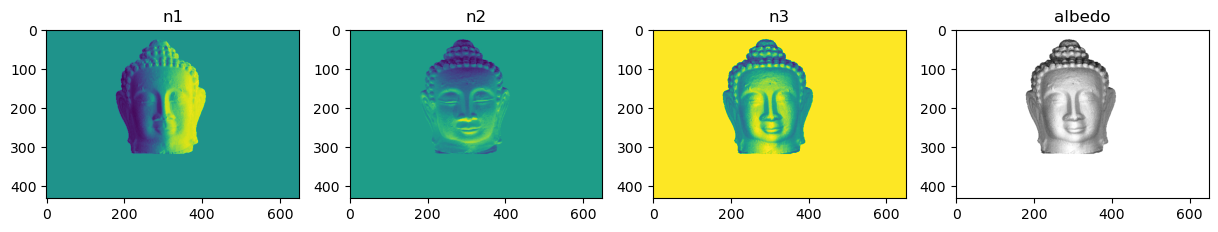

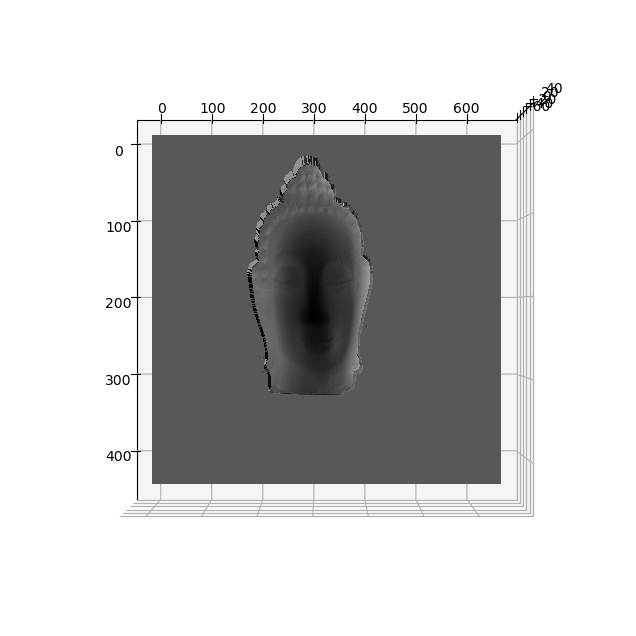

In [1]:
import numpy as np
import ps_utils
import numpy.linalg as la
import matplotlib.pyplot as plt

# read Beethoven data
I, mask, S = ps_utils.read_data_file('Buddha')

# get indices of non zero pixels in mask
nz = np.where(mask > 0)
m,n = mask.shape

# for each mask pixel, collect image data
J = np.zeros((S.shape[0], len(nz[0])))
for i in range(S.shape[0]):
    Ii = I[:,:,i]
    J[i,:] = Ii[nz] # (10, nz)

# solve for M = rho*N
piS = la.pinv(S)  # (3, 10)
M = np.dot(piS, J)  # (10, nz)

# get albedo as norm of M and normalize M
Rho = la.norm(M, axis=0)
N = M/np.tile(Rho, (3,1))

n1 = np.zeros((m,n))
n2 = np.zeros((m,n))
n3 = np.ones((m,n))
rho = np.ones((m,n))
n1[nz] = N[0,:]
n2[nz] = N[1,:]
n3[nz] = N[2,:]
rho[nz] = Rho[:]
plt.rcParams['figure.figsize'] = (15.0, 8.0)
_,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(n1)
ax1.set_title('n1')
ax2.imshow(n2)
ax2.set_title('n2')
ax3.imshow(n3)
ax3.set_title('n3')
ax4.imshow(n3, cmap='gray')
ax4.set_title('albedo')
plt.show()

z = ps_utils.unbiased_integrate(n1, n2, n3, mask)
ps_utils.display_surface(z)




Using RANSAC:

In [ ]:
# Load the data for the Buddha dataset
I, mask, S = read_data_file("Buddha.mat")
print(I.shape)
print(mask.shape)
print(S.shape)
# Get the size of the images and number of views
m, n, k = I.shape

albedo_matrix = np.zeros((mask.shape[0], mask.shape[1])) 
normals_matrix = np.zeros((mask.shape[0], mask.shape[1], 3)) 
albedo_matrix_30 = np.zeros((mask.shape[0], mask.shape[1])) 
normals_matrix_30 = np.zeros((mask.shape[0], mask.shape[1], 3)) 
albedo_matrix_40 = np.zeros((mask.shape[0], mask.shape[1])) 
normals_matrix_40 = np.zeros((mask.shape[0], mask.shape[1], 3)) 
albedo_matrix_50 = np.zeros((mask.shape[0], mask.shape[1])) 
normals_matrix_50 = np.zeros((mask.shape[0], mask.shape[1], 3)) 

(433, 650, 10)
(433, 650)
(10, 3)


1. Experiment with threshold.

In [ ]:
# traverse every pixel
def call_ransac(row_no, col_no, albedo_matrix, normals_matrix, threshold, I, S):
    for row in range(row_no):
        for col in range(col_no):
            if mask[row, col]:
                data = (I[row, col, :], S)
                modulated_normal, inliers, best_fit = ransac_3dvector(
                    data, threshold, max_data_tries=100, max_iters=1000, p=0.9, 
                    det_threshold=1e-1, verbose=2)
                albedo_matrix[row, col] = np.linalg.norm(modulated_normal)
                # Adding 0.0001 to albedo to avoid dividing-by-zero error. OR increase threshold.
                normals_matrix[row, col, :] = modulated_normal / (albedo_matrix[row, col] + 0.0001)
call_ransac(m, n, albedo_matrix, normals_matrix, 25, I, S)
call_ransac(m, n, albedo_matrix_30, normals_matrix_30, 30, I, S)
call_ransac(m, n, albedo_matrix_40, normals_matrix_40, 40, I, S)
call_ransac(m, n, albedo_matrix_50, normals_matrix_50, 50, I, S)

Analysis:


2. Display and comment on the the normals and the albedo.

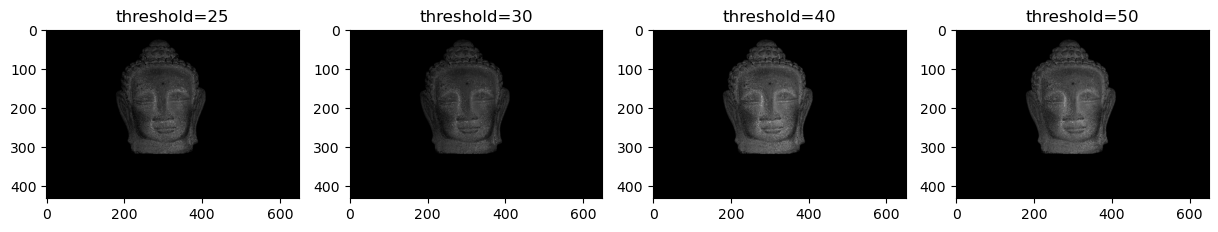

In [ ]:
# plot albedo 
# Make figures larger
plt.rcParams['figure.figsize'] = (15.0, 8.0)
_,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(albedo_matrix, cmap = 'gray')
ax1.set_title('threshold=25')
ax2.imshow(albedo_matrix_30, cmap = 'gray')
ax2.set_title('threshold=30')
ax3.imshow(albedo_matrix_40, cmap = 'gray')
ax3.set_title('threshold=40')
ax4.imshow(albedo_matrix_50, cmap = 'gray')
ax4.set_title('threshold=50')
plt.show()

Analysis:
1. The image of albedo resembles the raw image, which is quite interesting!
2. The brighter parts have higher albedo values and the darker parts have smaller albedo values.
3. As the threshold goes higher, the albedo image gets brighter.

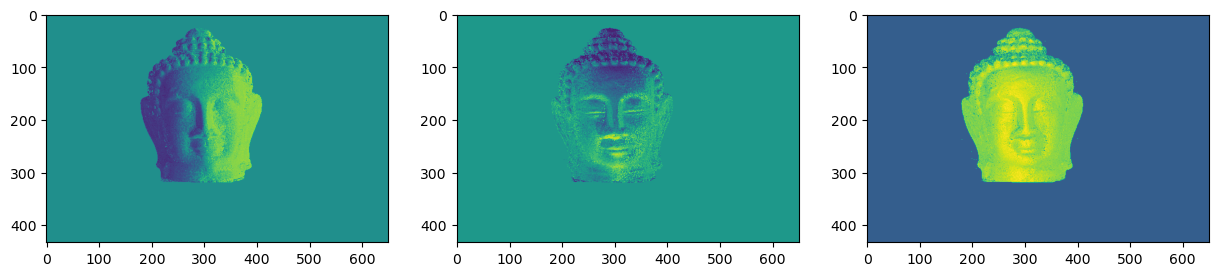

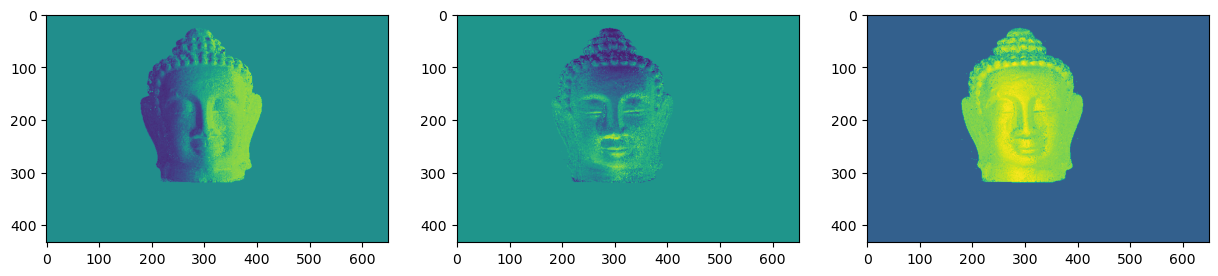

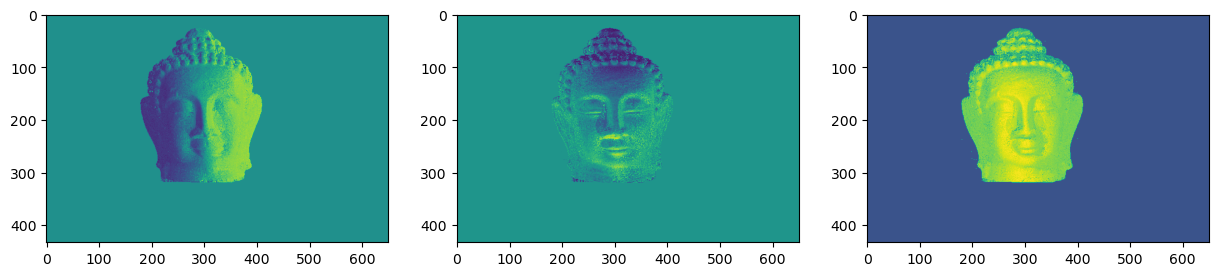

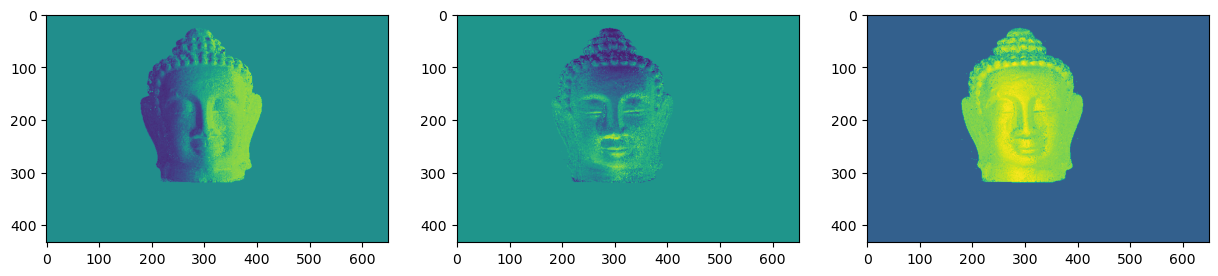

In [ ]:
# plot normals 
def plot_normals(normals_matrix):
    _,(ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.imshow(normals_matrix[:, :, 0])
    ax2.imshow(normals_matrix[:, :, 1])
    ax3.imshow(normals_matrix[:, :, 2])
    plt.show()
plot_normals(normals_matrix)
plot_normals(normals_matrix_30)
plot_normals(normals_matrix_40)
plot_normals(normals_matrix_30)

Analysis:
1. The images of the normals' components look like images that are taken under different light sources.
2. The normals contain information about the 3D structure of the object. 

3. Experiment with the iters parameter. 

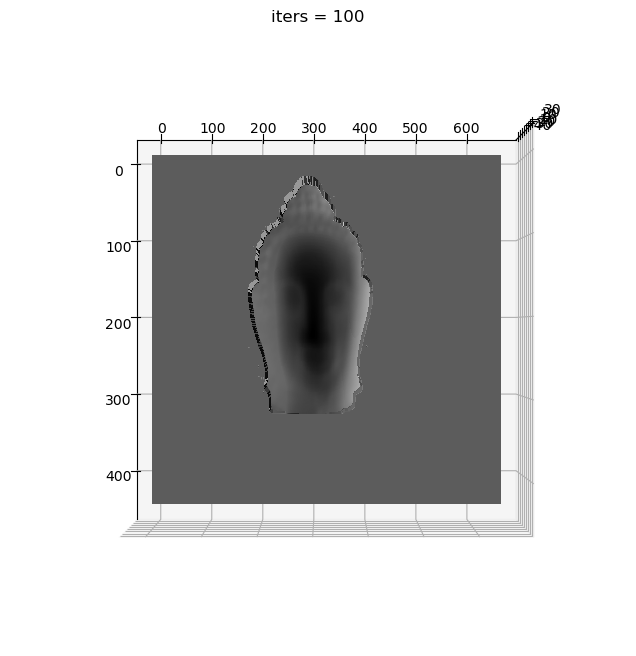

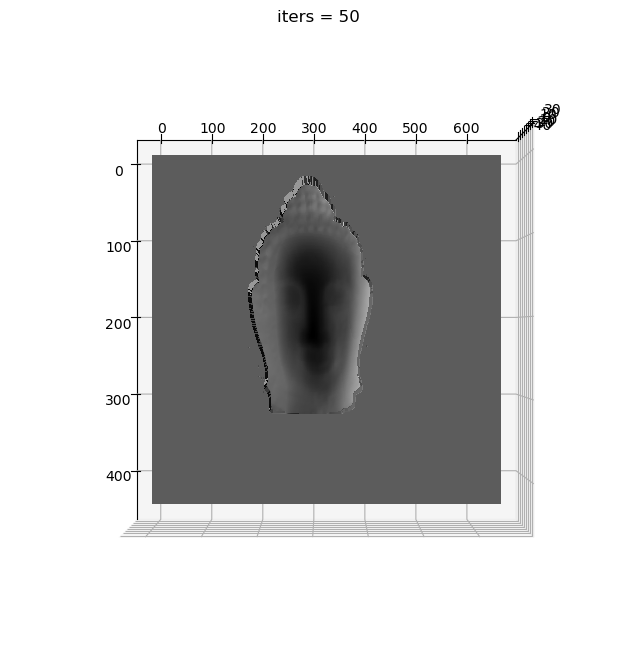

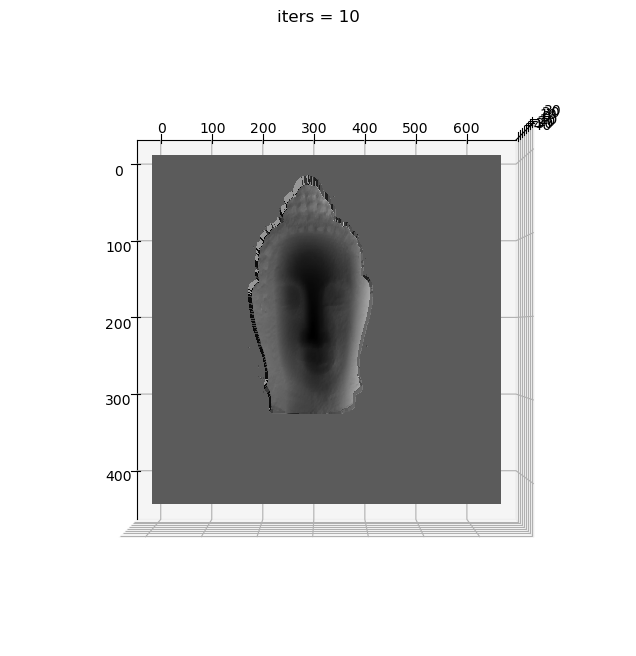

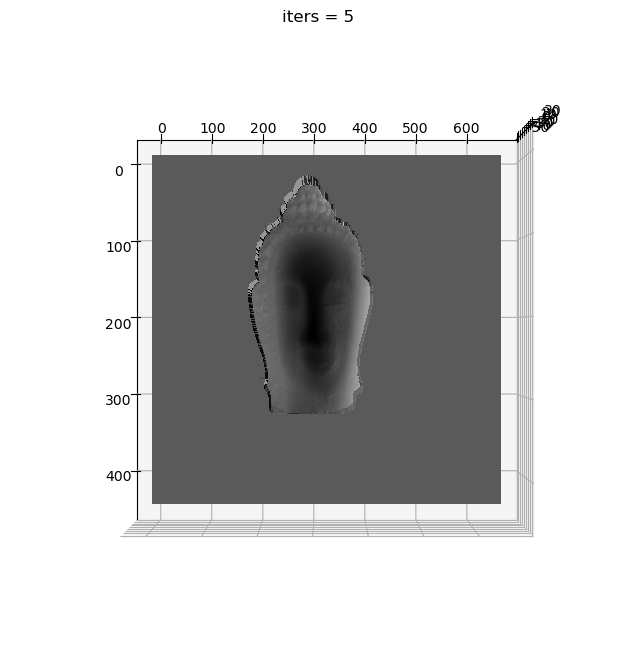

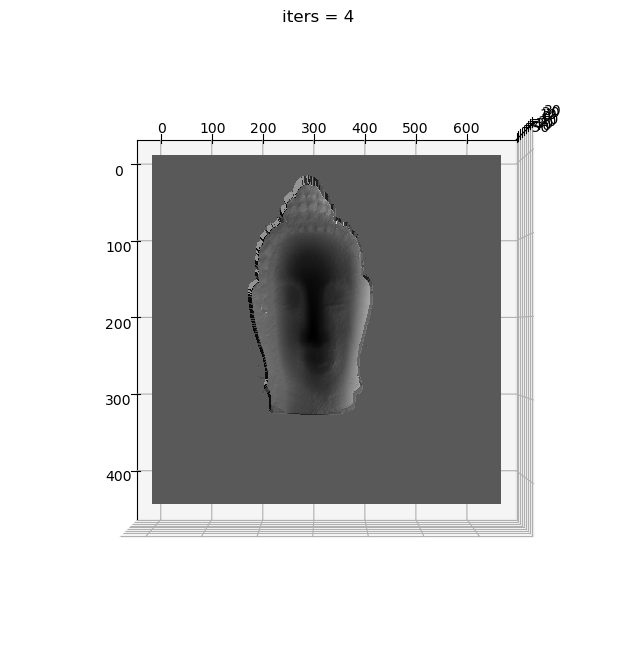

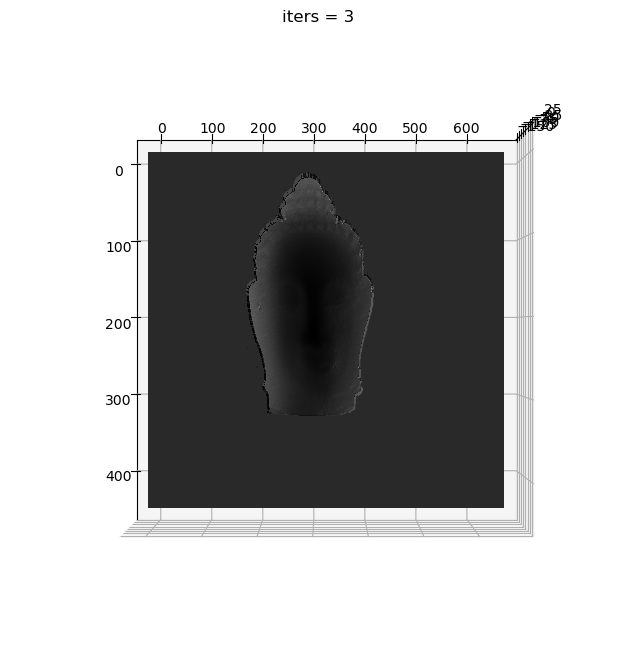

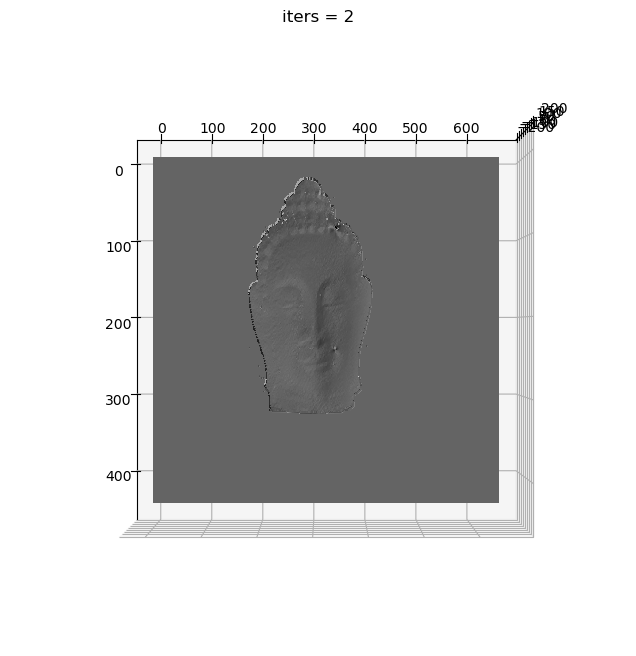

In [ ]:
# smoothing
def reconstruction(normals_matrix, mask, iters, elev=90, azim=0):
    (n1, n2, n3) = smooth_normal_field(normals_matrix[:,:,0], normals_matrix[:,:,1], 
                                       normals_matrix[:,:,2], mask, iters=iters)
    z = unbiased_integrate(n1, n2, n3, mask)
    display_surface(z, title=f'iters = {iters}', elev=elev, azim=azim)

reconstruction(normals_matrix, mask, 100)
reconstruction(normals_matrix, mask, 50)
reconstruction(normals_matrix, mask, 10)
reconstruction(normals_matrix, mask, 5)
reconstruction(normals_matrix, mask, 4)
reconstruction(normals_matrix, mask, 3)
reconstruction(normals_matrix, mask, 2)

# reconstruction(normals_matrix_50, mask, 100)
# reconstruction(normals_matrix_50, mask, 50)
# reconstruction(normals_matrix_50, mask, 10)
# reconstruction(normals_matrix_50, mask, 5)
# reconstruction(normals_matrix_50, mask, 4)
# reconstruction(normals_matrix_50, mask, 3)
# reconstruction(normals_matrix_50, mask, 2)




Analysis:
1. As the iter goes higher, the reconstructed surface becomes more smoothed and loses more details.
2. The best iter value for this case could be 10. In this case, the result is smoothed and contains enough details, e.g. eyes.

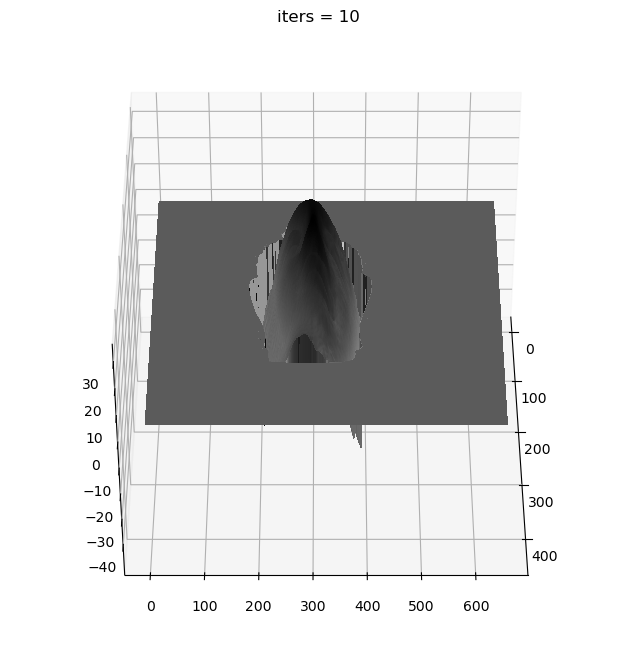

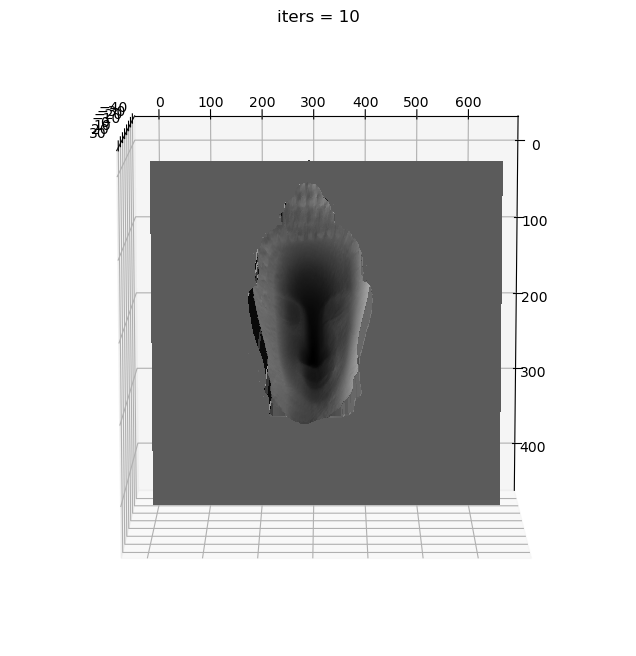

In [ ]:
reconstruction(normals_matrix, mask, 10, 40, 0)
reconstruction(normals_matrix, mask, 10, 100, 0)